The purpose of this notebook is to model the decoherence of a qubit. We use a rotationally invariant linear product of spins in the Pauli matrix representation as the interaction Hamiltonian. The expectation is that time evolution under such a Hamiltonian will result in entanglement between the qubit and its environment, yielding a reduced mixed-state density matrix recognized by non-zero eigenvalues.

N > 1: The qubit is entangled with a multi-qubit environment. 

v4: wrap simulation in function and call large number of times (100-1000) to calculate aggregate stats e.g. histograms of mean magnitude of off-diagonal reduced density matrix, histogram of eigenvalues of reduced density matrix

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import itertools

In [2]:
# helper functions
def create_env_basis_list(N):
    """
    Create 2^N different basis states from 0, 1

    Arguments:
    - N: The number of elements in the string to create.

    Returns:
    - perms: List of 2^N strings '0100...'
    """

    perms = list(itertools.product('01', repeat=N))
    
    return perms

def create_ham_order_list(N):
    """
    Create different permutations from 0, 1 for Hamiltonian

    Arguments:
    - N: The number of elements in the string to create.

    Returns:
    - perms: List of strings '0100...'
    """

    perms = list(itertools.permutations('0'*(N-1)+'1'))
    
    return perms

def run_quantum_sim(dt, num_steps, N, ham, q_global):
    """
    Runs the quantum sim and produces reduced density matrix

    Arguments:
    - dt: The timestep for solver.
    - num_steps: The number of timesteps over which to iterate.
    - N: The number of environmental qubits.
    - ham: The global Hamiltonian matrix.
    - q_global: The global quantum state (at the start of the sim and will be updated).

    Returns:
    - eigs_list: list of eigenvalues of the reduced density matrix across sim time 
    - rho_red_od_ll: list of 10 reduced density matrix elements across sim time
    - rho_red_od_ur: list of 01 reduced density matrix elements across sim time
    - rho_red_od_lr: list of 11 reduced density matrix elements across sim time
    - rho_red_od_ul: list of 00 reduced density matrix elements across sim time
    """
        
    # time evolve the global state d|psi> = -i*H|psi>dt

    # record the eigenvalues of the reduced density matrix
    eigs_list = []
    eigvects_list = []
    rho_red_od_ll = []
    rho_red_od_ur = []
    rho_red_od_lr = []
    rho_red_od_ul = []

    for step in range(num_steps):
        q_update = -i*dt*np.dot(ham, q_global)
        heun_term = np.linalg.inv(np.identity(ham.shape[0]) + .5*i*dt*ham) # trying 2nd order solver
        q_global = np.matmul(heun_term, (q_global + q_update*.5))
        q_global_norm = np.sqrt(np.dot(q_global.conj().T, q_global))
        q_global = q_global/(q_global_norm) # need to explicitly normalize since linearization is non-unitary at 2nd order
    
        # form the density matrix of the time-evolved global state
        rho_global = np.outer(q_global, q_global.conj().T)
    
        # trace out the environmental state
        # environmental basis states in global hilbert space
        list_of_env_basis_states = create_env_basis_list(N)
        rho_red = 0
        for perm in list_of_env_basis_states:
            env_basis_state = id_mat
            for j in perm: # note that order of elements in kronecker product will be reverse of perm, but will not matter in trace
                if j == '1':
                    env_basis_state = np.kron(up, env_basis_state)
                elif j == '0':
                    env_basis_state = np.kron(down, env_basis_state)
            rho_red = np.matmul(env_basis_state.conj().T, np.matmul(rho_global, env_basis_state)) + rho_red
    
        # calculate the eigenvalues of the reduced density matrix
        eigs = np.linalg.eigvals(rho_red)
        eigs_list.append(eigs)
    
        # calculate the eigenvectors of the reduced density matrix
        w, eigvects = np.linalg.eig(rho_red)
        eigvects_list.append(eigvects)
    
        # store the off-diagonal terms of the reduced density matrix
        rho_red_od_ll.append(np.linalg.norm(rho_red[1,0]))
        rho_red_od_ur.append(np.linalg.norm(rho_red[0,1]))
    
        # store the off-diagonal terms of the reduced density matrix
        rho_red_od_lr.append(np.linalg.norm(rho_red[1,1]))
        rho_red_od_ul.append(np.linalg.norm(rho_red[0,0]))
        
    return eigs_list, rho_red_od_ll, rho_red_od_ur, rho_red_od_lr, rho_red_od_ul

In [3]:
# define the qubit (our system)
up = np.array([1,0]).reshape(2,1)
down = np.array([0,1]).reshape(2,1)
    
c1 = np.sqrt(.9)
c2 = np.sqrt(.1)
qubit = np.array([c1, c2]) # c1|0> + c2|1>
qubit = qubit.reshape(2,1) # reshape as a 2x1 column vector

In [4]:
# define the environment (let's try N>1 now)
N = 3 # number of environmental qubits

q_env = up # get the ball rolling 
for n in range(N-1):
    #if np.round(np.random.rand()) == 0:
    q_env = np.kron(up, q_env)
    #else:
    #    q_env = np.kron(up, q_env)

In [5]:
# define the interaction Hamiltonian between qubit and evironment (linear product of spins)
# pauli matrices
i = complex(0,1)
id_mat = np.array([[1,0],[0,1]])
sigma_x = np.array([[0, 1], [1,0]])
sigma_y = np.array([[0, -i], [i,0]])
sigma_z = np.array([[1, 0], [0,-1]])

ham = 0
coupling = 100 # coupling strength between environment and qubit
'''
list_of_ham_orders = create_ham_order_list(N)
for perm in list_of_ham_orders:
    ham_x = sigma_x
    ham_y = sigma_y
    ham_z = sigma_z
    for j in perm: # note that order of elements in kronecker product will be reverse of perm, but will not matter in sum
        if j == '1':
            ham_x = np.kron(sigma_x, ham_x)
            ham_y = np.kron(sigma_y, ham_y)
            ham_z = np.kron(sigma_z, ham_z)
        elif j == '0':
            ham_x = np.kron(id_mat, ham_x)
            ham_y = np.kron(id_mat, ham_y)
            ham_z = np.kron(id_mat, ham_z)
    ham = ham + coupling*(ham_x + ham_y + ham_z)
'''

"\nlist_of_ham_orders = create_ham_order_list(N)\nfor perm in list_of_ham_orders:\n    ham_x = sigma_x\n    ham_y = sigma_y\n    ham_z = sigma_z\n    for j in perm: # note that order of elements in kronecker product will be reverse of perm, but will not matter in sum\n        if j == '1':\n            ham_x = np.kron(sigma_x, ham_x)\n            ham_y = np.kron(sigma_y, ham_y)\n            ham_z = np.kron(sigma_z, ham_z)\n        elif j == '0':\n            ham_x = np.kron(id_mat, ham_x)\n            ham_y = np.kron(id_mat, ham_y)\n            ham_z = np.kron(id_mat, ham_z)\n    ham = ham + coupling*(ham_x + ham_y + ham_z)\n"

In [6]:
# define the global combined state of qubit and environment
q_global = np.kron(q_env, qubit)

In [7]:
# time evolve the global state d|psi> = -i*H|psi>dt
dt = .1
num_steps = 5000 #50000

# run the sim and return the reduced density matrix elements + eigenvalues
num_sims = 100
all_eigs = []
all_rho_red_od_ll = []
all_rho_red_od_ur = []
all_rho_red_od_lr = []
all_rho_red_od_ul = []

for sim_count in range(num_sims):
    # trying arbitrary hermitian matrices as the hamiltonian
    ham = coupling*np.random.rand(2**(N+1), 2**(N+1)) + i*(np.random.rand(2**(N+1), 2**(N+1)))
    ham = (ham + ham.conj().T)/2
    eigs_list, rho_red_od_ll, rho_red_od_ur, rho_red_od_lr, rho_red_od_ul\
    = run_quantum_sim(dt, num_steps, N, ham, q_global)
    all_eigs.append(np.mean(eigs_list,0))
    all_rho_red_od_ll.append(np.mean(rho_red_od_ll))
    all_rho_red_od_ur.append(np.mean(rho_red_od_ur))
    all_rho_red_od_lr.append(np.mean(rho_red_od_lr))
    all_rho_red_od_ul.append(np.mean(rho_red_od_ul))

In [8]:
# prep arrays for plotting
eigs_arr = np.array(eigs_list)
eig1 = np.real(np.min(eigs_arr, 1))
eig2 = np.real(np.max(eigs_arr, 1))
t_arr = np.arange(0,dt*num_steps,dt)

smooth_window = 100 # units of dt
eig1_smooth = pd.Series(eig1).rolling(smooth_window, min_periods=1).mean()
eig2_smooth = pd.Series(eig2).rolling(smooth_window, min_periods=1).mean()
rho_red_od_ll_smooth = pd.Series(rho_red_od_ll).rolling(smooth_window, min_periods=1).mean()
rho_red_od_ur_smooth = pd.Series(rho_red_od_ur).rolling(smooth_window, min_periods=1).mean()
rho_red_od_lr_smooth = pd.Series(rho_red_od_lr).rolling(smooth_window, min_periods=1).mean()
rho_red_od_ul_smooth = pd.Series(rho_red_od_ul).rolling(smooth_window, min_periods=1).mean()

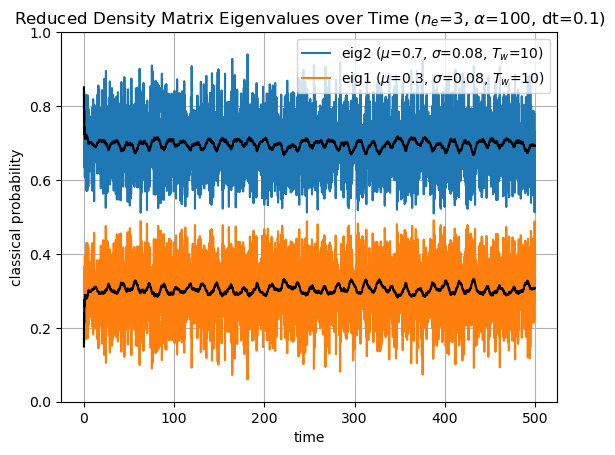

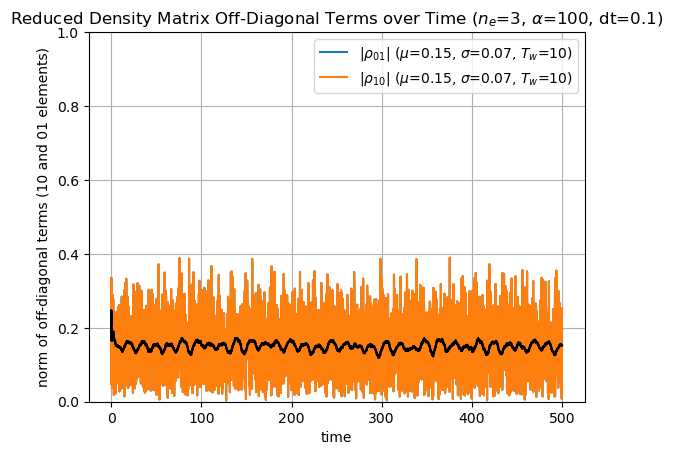

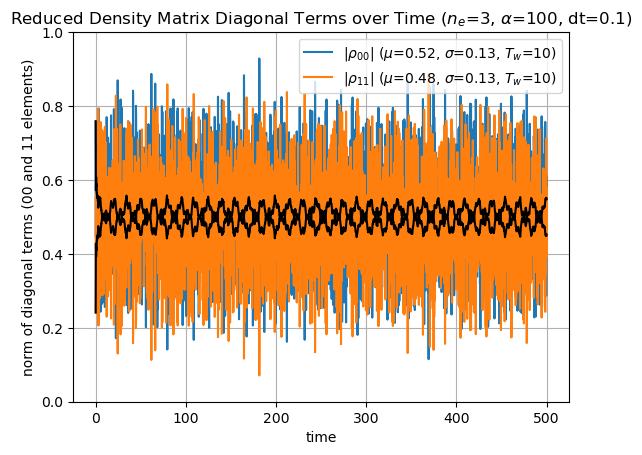

In [9]:
# plot the eigenvalues as a function of time
plt.figure()
plt.subplot()
plt.plot(t_arr, eig2,  label='eig2 ($\mu$='+str(np.round(np.mean(eig2),2))+\
         ', '+'$\sigma$='+str(np.round(np.std(eig2),2))+\
         ','+' $T_w$='+str(int(smooth_window*dt))+')')
plt.plot(t_arr, eig1, label='eig1 ($\mu$='+str(np.round(np.mean(eig1),2))+\
         ', '+'$\sigma$='+str(np.round(np.std(eig1),2))+\
         ','+' $T_w$='+str(int(smooth_window*dt))+')')
plt.plot(t_arr, eig1_smooth, color='black')
plt.plot(t_arr, eig2_smooth, color='black')
plt.grid()
plt.xlabel('time')
plt.ylabel('classical probability')
plt.title('Reduced Density Matrix Eigenvalues over Time ($n_e$='+str(N)+\
          r', $\alpha$='+str(coupling)+', dt='+str(dt)+')')
plt.ylim([0,1])
plt.legend()

plt.figure()
plt.subplot()
plt.plot(t_arr, rho_red_od_ur, label=r'$|\rho_{01}|$ ($\mu$='+str(np.round(np.mean(rho_red_od_ll),2))+\
         ', '+'$\sigma$='+str(np.round(np.std(rho_red_od_ll),2))+\
         ','+' $T_w$='+str(int(smooth_window*dt))+')')
plt.plot(t_arr, rho_red_od_ll, label=r'$|\rho_{10}|$ ($\mu$='+str(np.round(np.mean(rho_red_od_ll),2))+\
         ', '+'$\sigma$='+str(np.round(np.std(rho_red_od_ll),2))+\
         ','+' $T_w$='+str(int(smooth_window*dt))+')')
plt.plot(t_arr, rho_red_od_ll_smooth, color='black')
plt.plot(t_arr, rho_red_od_ur_smooth, color='black')
plt.grid()
plt.xlabel('time')
plt.ylabel('norm of off-diagonal terms (10 and 01 elements)')
plt.title('Reduced Density Matrix Off-Diagonal Terms over Time ($n_e$='+str(N)+\
          r', $\alpha$='+str(coupling)+', dt='+str(dt)+')')
plt.ylim([0,1])
plt.legend()

plt.figure()
plt.subplot()
plt.plot(t_arr, rho_red_od_ul, label=r'$|\rho_{00}|$ ($\mu$='+str(np.round(np.mean(rho_red_od_ul),2))+\
         ', '+'$\sigma$='+str(np.round(np.std(rho_red_od_ul),2))+\
         ','+' $T_w$='+str(int(smooth_window*dt))+')')
plt.plot(t_arr, rho_red_od_lr, label=r'$|\rho_{11}|$ ($\mu$='+str(np.round(np.mean(rho_red_od_lr),2))+\
         ', '+'$\sigma$='+str(np.round(np.std(rho_red_od_lr),2))+\
         ','+' $T_w$='+str(int(smooth_window*dt))+')')
plt.plot(t_arr, rho_red_od_ul_smooth, color='black')
plt.plot(t_arr, rho_red_od_lr_smooth, color='black')
plt.grid()
plt.xlabel('time')
plt.ylabel('norm of diagonal terms (00 and 11 elements)')
plt.title('Reduced Density Matrix Diagonal Terms over Time ($n_e$='+str(N)+\
          r', $\alpha$='+str(coupling)+', dt='+str(dt)+')')
plt.ylim([0,1])
plt.legend()

C:\Users\rohit\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6793: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


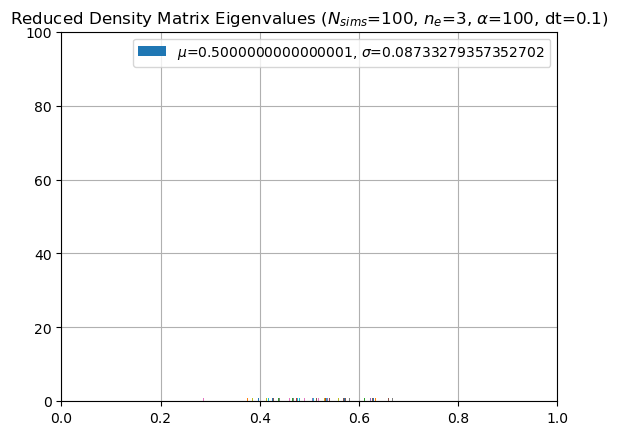

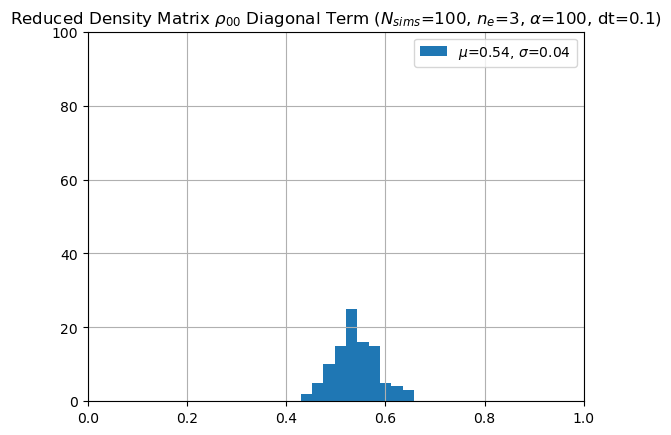

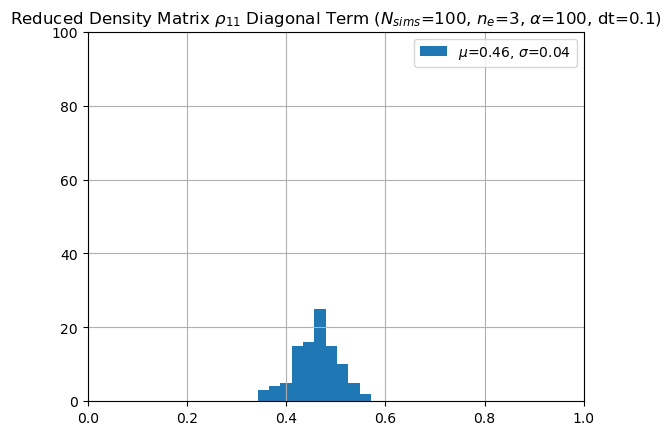

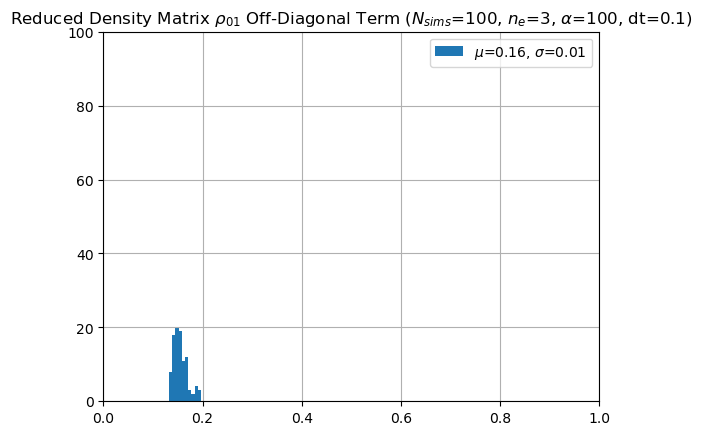

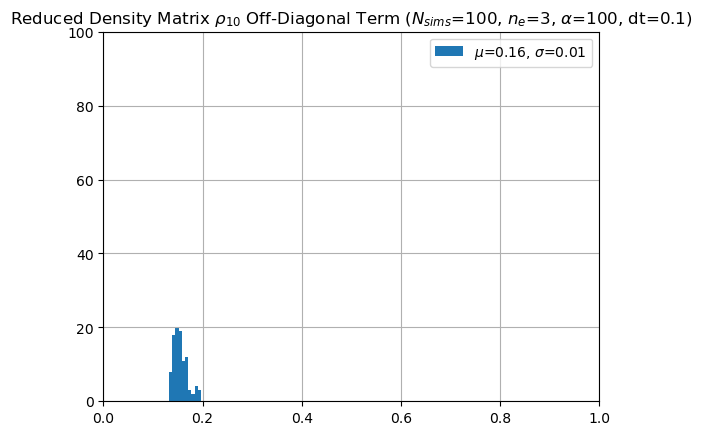

In [10]:
# plot the histograms
binwidth = .01

# histogram of eigenvalues
plt.figure()
plt.hist(all_eigs, label=r'$\mu$='+str(np.mean(np.real(all_eigs)))+r', $\sigma$='+str(np.std(all_eigs)))
plt.xlim([0,1])
plt.ylim([0, num_sims])
plt.grid()
plt.title('Reduced Density Matrix Eigenvalues ($N_{sims}$='+str(num_sims)+', $n_e$='+str(N)+\
          r', $\alpha$='+str(coupling)+', dt='+str(dt)+')')
plt.legend()

# histogram of rho_00
plt.figure()
plt.hist(all_rho_red_od_ul, label=r'$\mu$='+str(np.round(np.mean(all_rho_red_od_ul),2))+\
         r', $\sigma$='+str(np.round(np.std(all_rho_red_od_ul),2)))
plt.xlim([0,1])
plt.ylim([0, num_sims])
plt.grid()
plt.title(r'Reduced Density Matrix $\rho_{00}$ Diagonal Term ($N_{sims}$='+str(num_sims)+', $n_e$='+str(N)+\
          r', $\alpha$='+str(coupling)+', dt='+str(dt)+')')
plt.legend()

# histogram of rho_11
plt.figure()
plt.hist(all_rho_red_od_lr, label=r'$\mu$='+str(np.round(np.mean(all_rho_red_od_lr),2))+\
         r', $\sigma$='+str(np.round(np.std(all_rho_red_od_lr),2)))
plt.xlim([0,1])
plt.ylim([0, num_sims])
plt.grid()
plt.title(r'Reduced Density Matrix $\rho_{11}$ Diagonal Term ($N_{sims}$='+str(num_sims)+', $n_e$='+str(N)+\
          r', $\alpha$='+str(coupling)+', dt='+str(dt)+')')
plt.legend()

# histogram of rho_01
plt.figure()
plt.hist(all_rho_red_od_ur, label=r'$\mu$='+str(np.round(np.mean(all_rho_red_od_ur),2))+\
         r', $\sigma$='+str(np.round(np.std(all_rho_red_od_ur),2)))
plt.xlim([0,1])
plt.ylim([0, num_sims])
plt.grid()
plt.title(r'Reduced Density Matrix $\rho_{01}$ Off-Diagonal Term ($N_{sims}$='+str(num_sims)+', $n_e$='+str(N)+\
          r', $\alpha$='+str(coupling)+', dt='+str(dt)+')')
plt.legend()

# histogram of rho_10
plt.figure()
plt.hist(all_rho_red_od_ll, label=r'$\mu$='+str(np.round(np.mean(all_rho_red_od_ll),2))+\
         r', $\sigma$='+str(np.round(np.std(all_rho_red_od_ll),2)))#,\
#         bins=np.arange(0, 1 + binwidth, binwidth))
plt.xlim([0,1])
plt.ylim([0, num_sims])
plt.grid()
plt.title(r'Reduced Density Matrix $\rho_{10}$ Off-Diagonal Term ($N_{sims}$='+str(num_sims)+', $n_e$='+str(N)+\
          r', $\alpha$='+str(coupling)+', dt='+str(dt)+')')
plt.legend()

# Scratch Work

In [11]:
all_rho_red_od_ul

[0.5391937782797457,
 0.563022692765108,
 0.5696109588672933,
 0.5056535581385215,
 0.5226232180895679,
 0.48841970114625366,
 0.5015886588695685,
 0.5692819438077148,
 0.5640453676877054,
 0.509124377438769,
 0.5225376584012683,
 0.4621566805677823,
 0.5688645936449673,
 0.4934547947487279,
 0.510030102151216,
 0.6573017891967627,
 0.5239585147240641,
 0.4433410186263217,
 0.5440233729638607,
 0.5552502042233476,
 0.6382813429531764,
 0.5422085220424752,
 0.532212971646366,
 0.5895049885381409,
 0.5089751645172969,
 0.5044499511431307,
 0.5361650045252648,
 0.5193154043029258,
 0.5504650770671133,
 0.4730057640938396,
 0.5512799447324982,
 0.5886531026432477,
 0.5704322086888443,
 0.5332597308064092,
 0.5679622972807511,
 0.6002511340839556,
 0.492198600174471,
 0.5200788551866347,
 0.5641479348113642,
 0.5811238236674688,
 0.46713054203578885,
 0.5448401206422483,
 0.53382489561935,
 0.5080354647706375,
 0.529389646987433,
 0.5399859772094195,
 0.6485780832057284,
 0.5624513258052826

In [12]:
all_rho_red_od_lr, np.std(all_rho_red_od_lr)

([0.4608062217202543,
  0.43697730723489203,
  0.4303890411327067,
  0.49434644186147864,
  0.4773767819104323,
  0.5115802988537465,
  0.49841134113043156,
  0.43071805619228537,
  0.4359546323122947,
  0.490875622561231,
  0.47746234159873163,
  0.5378433194322176,
  0.4311354063550329,
  0.5065452052512721,
  0.48996989784878403,
  0.3426982108032373,
  0.47604148527593604,
  0.5566589813736784,
  0.4559766270361394,
  0.4447497957766525,
  0.36171865704682366,
  0.45779147795752495,
  0.467787028353634,
  0.41049501146185924,
  0.49102483548270337,
  0.4955500488568694,
  0.4638349954747353,
  0.4806845956970743,
  0.4495349229328868,
  0.5269942359061606,
  0.44872005526750197,
  0.41134689735675256,
  0.4295677913111558,
  0.46674026919359096,
  0.43203770271924896,
  0.39974886591604447,
  0.5078013998255292,
  0.47992114481336556,
  0.4358520651886359,
  0.4188761763325312,
  0.5328694579642113,
  0.4551598793577518,
  0.46617510438065,
  0.4919645352293626,
  0.470610353012567

In [13]:
all_rho_red_od_ll

[0.1845469608801642,
 0.14208926540645628,
 0.1660141563638629,
 0.16301458010545664,
 0.148001238456624,
 0.14866875266703186,
 0.1442227153603951,
 0.1576095340982118,
 0.14017387368576184,
 0.18294457514006068,
 0.16178906378634653,
 0.14619570606781582,
 0.14861992243425537,
 0.1779082505810287,
 0.19663028194714438,
 0.1698117369886015,
 0.14479503636250354,
 0.15462782144241694,
 0.14937310064441103,
 0.15297570830759663,
 0.155308861032412,
 0.15691775785288656,
 0.1412338738150232,
 0.13496688861841546,
 0.13670668524224824,
 0.1405071191697205,
 0.15641723131564997,
 0.14996587124615934,
 0.15440182850144196,
 0.18786366330585594,
 0.16735630145857885,
 0.14507651594897697,
 0.16133698848461012,
 0.16064823281879054,
 0.16016254830704346,
 0.1696978875883251,
 0.1521090458854574,
 0.17029775628050794,
 0.16871651443793917,
 0.1952536633479139,
 0.15592437154715855,
 0.1553086302933837,
 0.15262368969575132,
 0.14721677229779967,
 0.17350758152939447,
 0.13832602873406796,
 0.1

In [14]:
all_rho_red_od_ur

[0.1845469608801642,
 0.14208926540645628,
 0.1660141563638629,
 0.16301458010545664,
 0.148001238456624,
 0.14866875266703186,
 0.1442227153603951,
 0.1576095340982118,
 0.14017387368576184,
 0.18294457514006068,
 0.16178906378634653,
 0.14619570606781582,
 0.14861992243425537,
 0.1779082505810287,
 0.19663028194714438,
 0.1698117369886015,
 0.14479503636250354,
 0.15462782144241694,
 0.14937310064441103,
 0.15297570830759663,
 0.155308861032412,
 0.15691775785288656,
 0.1412338738150232,
 0.13496688861841546,
 0.13670668524224824,
 0.1405071191697205,
 0.15641723131564997,
 0.14996587124615934,
 0.15440182850144196,
 0.18786366330585594,
 0.16735630145857885,
 0.14507651594897697,
 0.16133698848461012,
 0.16064823281879054,
 0.16016254830704346,
 0.1696978875883251,
 0.1521090458854574,
 0.17029775628050794,
 0.16871651443793917,
 0.1952536633479139,
 0.15592437154715855,
 0.1553086302933837,
 0.15262368969575132,
 0.14721677229779967,
 0.17350758152939447,
 0.13832602873406796,
 0.1

In [15]:
str(np.mean(all_eigs))

'(0.5000000000000001-4.1975820961600716e-21j)'

In [16]:
all_eigs

[array([0.56852778-1.20282818e-19j, 0.43147222+1.20922667e-19j]),
 array([0.60407109+2.06030818e-20j, 0.39592891+5.36037806e-20j]),
 array([0.60265087-1.63972471e-19j, 0.39734913-1.17963462e-19j]),
 array([0.51426989+2.33596521e-20j, 0.48573011-8.84009404e-20j]),
 array([0.53204411-1.09258880e-19j, 0.46795589-4.91444125e-20j]),
 array([0.48913216+4.11454375e-21j, 0.51086784+1.91822473e-19j]),
 array([0.50106592+8.28128731e-21j, 0.49893408+2.73708856e-19j]),
 array([0.60816613-7.12612626e-20j, 0.39183387+2.66650161e-21j]),
 array([0.5844112-3.40899560e-20j, 0.4155888+8.27597915e-20j]),
 array([0.51220065-1.88875402e-19j, 0.48779935-2.89039561e-19j]),
 array([0.53894762-5.91606202e-22j, 0.46105238+2.41838455e-20j]),
 array([0.44944457-7.01029235e-20j, 0.55055543+2.38411758e-19j]),
 array([0.60108741+2.11408701e-20j, 0.39891259-1.14398520e-19j]),
 array([0.48380736-7.14748107e-20j, 0.51619264-1.61368448e-19j]),
 array([0.51914159+2.15164941e-19j, 0.48085841-9.21134152e-20j]),
 array([0.73